# <center>__Data Cleaning Assignment__</center>

In [2]:
"""import necessary packages"""

import re
import numpy as np
import pandas as pd
import scipy.stats as stats
import missingno as msngo


## *Data Cleaning*

### Objectives
- Get column names from metadata file (census_income_metadata.txt) and apply to census data
- Inspect the data
    - Inspect text data and clean/normalize where applicable
    - Determine unique values (levels) for categorical data
- Handle missing data appropriately
- Ensure proper datatype for each feature

In [3]:
"""read in the data"""

census_income_train = pd.read_csv('census_income_train.csv', header=None)
census_income_test = pd.read_csv('census_income_test.csv', header=None)

In [4]:
"""create a dictionary to store feature names and associated metadata"""

metadata = open('census_income_metadata.txt')
metadata = metadata.readlines()[142:184]
metadata_dict = {}
for line in metadata:
    key = re.search(r'.*(?=:)', line).group().replace(" ", '_')
    key = re.sub(f'[^\w\d_]', '', key)
    value = re.search(r'(?<=:).*', line).group()
    value = re.sub(r'[\n\.]', '', value)
    value = value.strip()
    value = [val.strip() for val in value.split(',')]
    metadata_dict[key] = value
metadata_dict['outcome'] = ['- 50000', '50000+']

In [5]:
"""
get column names from metadata dict and apply to train and test data
drop instance weight feature form training and test sets
colnames list will be re-used durig data cleaning process, remove instance_weight from list
"""

colnames = list(metadata_dict.keys())
colnames.remove('_instance_weight')
census_income_train.columns = colnames
census_income_test.columns = colnames
census_income_train.drop(columns=['instance_weight'], inplace=True)
census_income_test.drop(columns=['instance_weight'], inplace=True)
colnames.remove('instance_weight')

Clean Text Data

In [6]:
"""
check dtype to identify columns containing text data
remove . in target, strip whitespace
"""
for col in colnames:
    if census_income_train[col].dtype == 'object':
        census_income_train[col] = census_income_train[col].str.replace('.', '', regex=False)
        census_income_train[col] = census_income_train[col].str.strip()
    if census_income_test[col].dtype == 'object':
        census_income_test[col] = census_income_test[col].str.replace('.', '', regex=False)
        census_income_test[col] = census_income_test[col].str.strip()

In [7]:
"""
create list of proper data types for each feature as specified in census_income_metadata.txt
"""

continuous_features = ['age', 'wage_per_hour', 'capital_gains', 'capital_losses',
                       'dividends_from_stocks', 'num_persons_worked_for_employer',
                       'weeks_worked_in_year']
nominal_features = [feature for feature in colnames if feature not in continuous_features]

Check Unique Values in Data

In [8]:
"""
instantiate dictionaries to store problem values idnetified in train and test sets
problem values will be determined by comparing unique values in the data to known set of unique values specified
in census_income_metadata.txt
"""
# create dictionaries
train_problem_values_dict = {}
test_problem_values_dict = {}
# get unique values from each column in train and test sets, compute set difference between actual and expected unique values
for col in nominal_features:
    unique_vals_train = set([str(val) for val in census_income_train[col].unique()])
    unique_vals_test = set([str(val) for val in census_income_test[col].unique()])
    unique_vals_metadata = set(metadata_dict[col])
    train_problem_values_dict[col] = list(unique_vals_train - unique_vals_metadata)
    test_problem_values_dict[col] = list(unique_vals_test - unique_vals_metadata)

In [9]:
"""print problem values idntified in training set"""
print(train_problem_values_dict)

{'class_of_worker': [], 'detailed_industry_recode': [], 'detailed_occupation_recode': [], 'education': [], 'enroll_in_edu_inst_last_wk': [], 'marital_stat': [], 'major_industry_code': [], 'major_occupation_code': [], 'race': [], 'hispanic_origin': [], 'sex': [], 'member_of_a_labor_union': [], 'reason_for_unemployment': [], 'full_or_part_time_employment_stat': [], 'tax_filer_stat': [], 'region_of_previous_residence': [], 'state_of_previous_residence': ['?'], 'detailed_household_and_family_stat': [], 'detailed_household_summary_in_household': [], 'migration_codechange_in_msa': ['?'], 'migration_codechange_in_reg': ['?'], 'migration_codemove_within_reg': ['?'], 'live_in_this_house_1_year_ago': [], 'migration_prev_res_in_sunbelt': ['?'], 'family_members_under_18': [], 'country_of_birth_father': ['?'], 'country_of_birth_mother': ['?'], 'country_of_birth_self': ['?'], 'citizenship': [], 'own_business_or_self_employed': [], 'fill_inc_questionnaire_for_veterans_admin': [], 'veterans_benefits':

In [10]:
"""print problem values identified in the test set"""
print(test_problem_values_dict)

{'class_of_worker': [], 'detailed_industry_recode': [], 'detailed_occupation_recode': [], 'education': [], 'enroll_in_edu_inst_last_wk': [], 'marital_stat': [], 'major_industry_code': [], 'major_occupation_code': [], 'race': [], 'hispanic_origin': [], 'sex': [], 'member_of_a_labor_union': [], 'reason_for_unemployment': [], 'full_or_part_time_employment_stat': [], 'tax_filer_stat': [], 'region_of_previous_residence': [], 'state_of_previous_residence': ['?'], 'detailed_household_and_family_stat': [], 'detailed_household_summary_in_household': [], 'migration_codechange_in_msa': ['?'], 'migration_codechange_in_reg': ['?'], 'migration_codemove_within_reg': ['?'], 'live_in_this_house_1_year_ago': [], 'migration_prev_res_in_sunbelt': ['?'], 'family_members_under_18': [], 'country_of_birth_father': ['?'], 'country_of_birth_mother': ['?'], 'country_of_birth_self': ['?'], 'citizenship': [], 'own_business_or_self_employed': [], 'fill_inc_questionnaire_for_veterans_admin': [], 'veterans_benefits':

Comparison of unique values in the training and test sets to unique values in census_income_metadata.txt shows the existence of a single problem value "?." This value will be treated as missing and replaced with "None."

In [11]:
"""change records with ? to None dtype"""
census_income_train = census_income_train.applymap(lambda x : None if x == '?' else x)
census_income_test = census_income_test.applymap(lambda x : None if x == '?' else x)

In [12]:
"""verify ? has been replaced with None in train set"""

'?' in census_income_train.values

False

In [13]:
"""verify ? has been replaced with None in test set"""

'?' in census_income_test.values

False

Check Missing Values and Missingness Mechanism in Data

In [14]:
"""print count of missing continuous features in train set"""

census_income_train[continuous_features].isnull().sum()

age                                0
wage_per_hour                      0
capital_gains                      0
capital_losses                     0
dividends_from_stocks              0
num_persons_worked_for_employer    0
weeks_worked_in_year               0
dtype: int64

In [15]:
"""print count of missing continuous features in test set"""

census_income_train[continuous_features].isnull().sum()

age                                0
wage_per_hour                      0
capital_gains                      0
capital_losses                     0
dividends_from_stocks              0
num_persons_worked_for_employer    0
weeks_worked_in_year               0
dtype: int64

In [16]:
"""print count of missing nominal features in train set"""

census_income_train[nominal_features].isnull().sum()

class_of_worker                                  0
detailed_industry_recode                         0
detailed_occupation_recode                       0
education                                        0
enroll_in_edu_inst_last_wk                       0
marital_stat                                     0
major_industry_code                              0
major_occupation_code                            0
race                                             0
hispanic_origin                                  0
sex                                              0
member_of_a_labor_union                          0
reason_for_unemployment                          0
full_or_part_time_employment_stat                0
tax_filer_stat                                   0
region_of_previous_residence                     0
state_of_previous_residence                    708
detailed_household_and_family_stat               0
detailed_household_summary_in_household          0
migration_codechange_in_msa    

In [17]:
"""print count of missing nominal features in test set"""

census_income_test[nominal_features].isnull().sum()

class_of_worker                                  0
detailed_industry_recode                         0
detailed_occupation_recode                       0
education                                        0
enroll_in_edu_inst_last_wk                       0
marital_stat                                     0
major_industry_code                              0
major_occupation_code                            0
race                                             0
hispanic_origin                                  0
sex                                              0
member_of_a_labor_union                          0
reason_for_unemployment                          0
full_or_part_time_employment_stat                0
tax_filer_stat                                   0
region_of_previous_residence                     0
state_of_previous_residence                    330
detailed_household_and_family_stat               0
detailed_household_summary_in_household          0
migration_codechange_in_msa    

In [18]:
"""drop columns missing more than 30% of data from train set"""

perc = 0.70
threshold = int(perc*census_income_train.shape[0])
census_income_train.dropna(axis=1, thresh=threshold, inplace=True)
# update nominal features index to account for dropped features
nominal_features = [feature for feature in census_income_train.columns.values.tolist() if feature not in continuous_features]

In [19]:
"""drop columns missing more than 30% of data from test set"""

perc = 0.70
threshold = int(perc*census_income_test.shape[0])
census_income_test.dropna(axis=1, thresh=threshold, inplace=True)
# update nominal features index to account for dropped features
nominal_features = [feature for feature in census_income_test.columns.values.tolist() if feature not in continuous_features]

In [20]:
"""determine total percentage of records with at least one missing attribute train set"""

census_income_train.isnull().any(axis=1).mean()*100

4.491712734872672

In [21]:
"""determine total percentage of records with at least one missing attribute test set"""

census_income_test.isnull().any(axis=1).mean()*100

4.554840520438644

<AxesSubplot:>

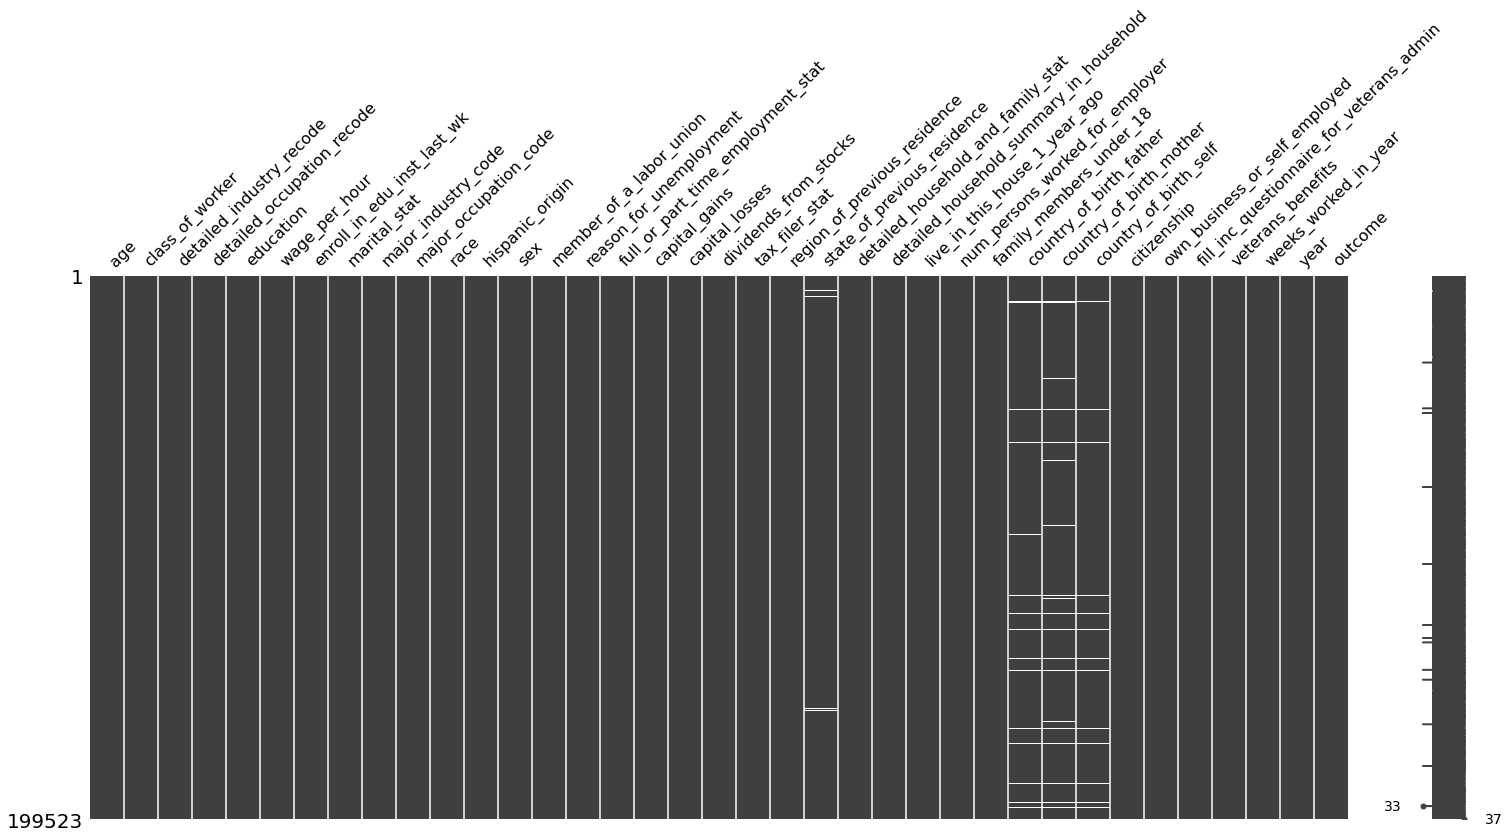

In [22]:
"""
print missing matrix for train set using missingo module
missing matrix will provide high-level view of missingness mechanism (MCAR, MAR, NMAR)
"""
msngo.matrix(census_income_train)

<AxesSubplot:>

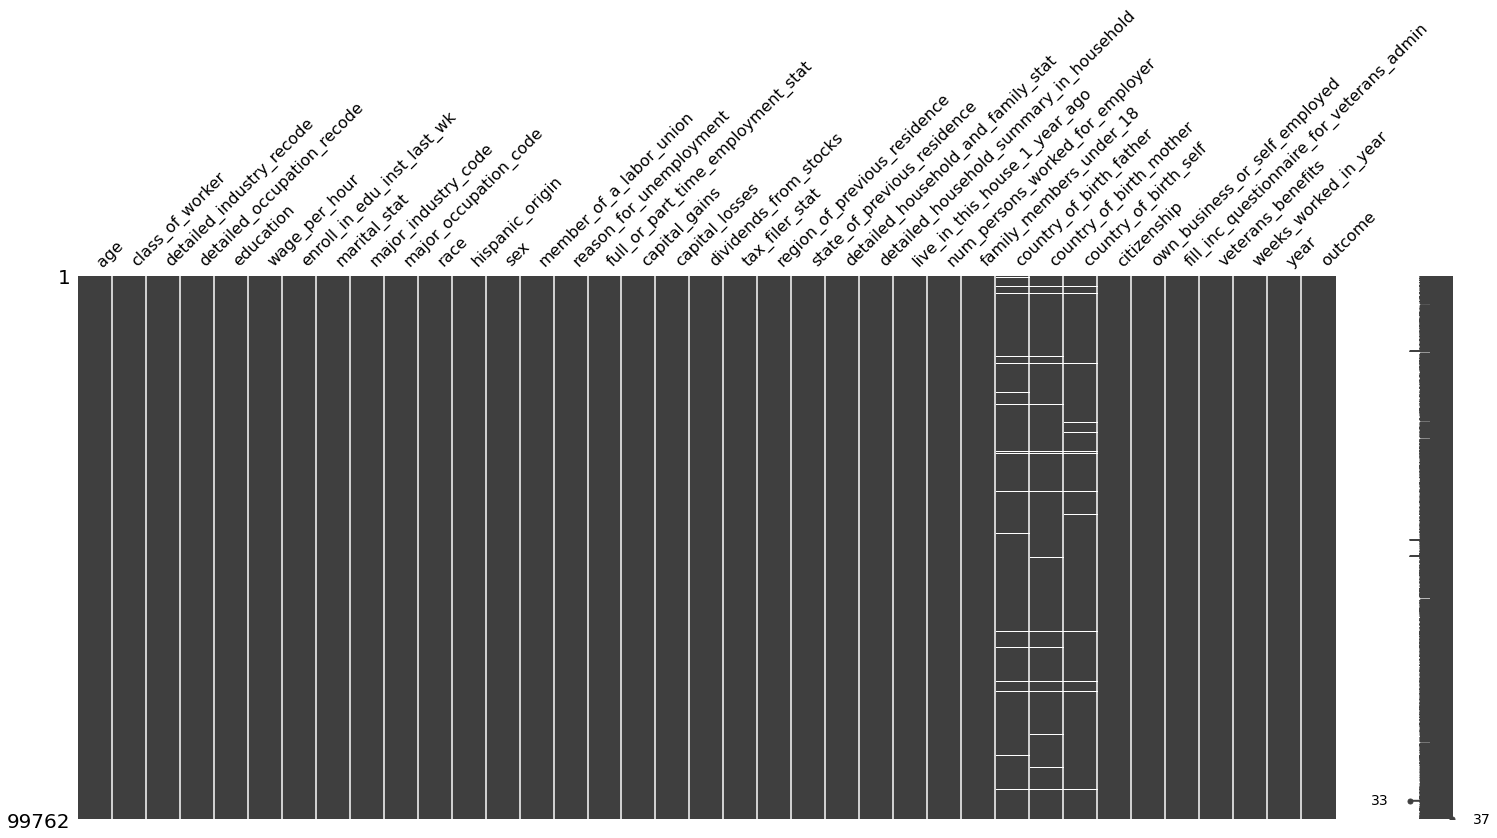

In [23]:
"""
print missing matrix for test set using missingo module
missing matrix will provide high-level view of missingness mechanism (MCAR, MAR, NMAR)
"""

msngo.matrix(census_income_test)

Examining the missingness matrix it's clear that missing data in both the training and test sets is not missing completely at random (MCAR). Since less the 5% of records are missing data and the misssingness mechanism is not MCAR remaining records with misssing attributes will be dropped.

In [24]:
"""drop records with missing attributes from train set"""
census_income_train.dropna(axis=0, inplace=True)
census_income_train.isnull().sum()

age                                          0
class_of_worker                              0
detailed_industry_recode                     0
detailed_occupation_recode                   0
education                                    0
wage_per_hour                                0
enroll_in_edu_inst_last_wk                   0
marital_stat                                 0
major_industry_code                          0
major_occupation_code                        0
race                                         0
hispanic_origin                              0
sex                                          0
member_of_a_labor_union                      0
reason_for_unemployment                      0
full_or_part_time_employment_stat            0
capital_gains                                0
capital_losses                               0
dividends_from_stocks                        0
tax_filer_stat                               0
region_of_previous_residence                 0
state_of_prev

In [25]:
"""drop records with missing attributes from test set"""
census_income_test.dropna(axis=0, inplace=True)
census_income_test.isnull().sum()

age                                          0
class_of_worker                              0
detailed_industry_recode                     0
detailed_occupation_recode                   0
education                                    0
wage_per_hour                                0
enroll_in_edu_inst_last_wk                   0
marital_stat                                 0
major_industry_code                          0
major_occupation_code                        0
race                                         0
hispanic_origin                              0
sex                                          0
member_of_a_labor_union                      0
reason_for_unemployment                      0
full_or_part_time_employment_stat            0
capital_gains                                0
capital_losses                               0
dividends_from_stocks                        0
tax_filer_stat                               0
region_of_previous_residence                 0
state_of_prev

In [26]:
"""check data types census_income_test"""
census_income_train[continuous_features].dtypes

age                                int64
wage_per_hour                      int64
capital_gains                      int64
capital_losses                     int64
dividends_from_stocks              int64
num_persons_worked_for_employer    int64
weeks_worked_in_year               int64
dtype: object

In [27]:
"""check data types census_income_test"""

census_income_test[continuous_features].dtypes

age                                int64
wage_per_hour                      int64
capital_gains                      int64
capital_losses                     int64
dividends_from_stocks              int64
num_persons_worked_for_employer    int64
weeks_worked_in_year               int64
dtype: object

In [28]:
"""convert nominal features to type category, census_income_train"""
census_income_train[nominal_features] = census_income_train[nominal_features].astype('category')
census_income_train[nominal_features].dtypes

class_of_worker                              category
detailed_industry_recode                     category
detailed_occupation_recode                   category
education                                    category
enroll_in_edu_inst_last_wk                   category
marital_stat                                 category
major_industry_code                          category
major_occupation_code                        category
race                                         category
hispanic_origin                              category
sex                                          category
member_of_a_labor_union                      category
reason_for_unemployment                      category
full_or_part_time_employment_stat            category
tax_filer_stat                               category
region_of_previous_residence                 category
state_of_previous_residence                  category
detailed_household_and_family_stat           category
detailed_household_summary_i

In [29]:
"""convert nominal features to type category, census_income_test"""
census_income_test[nominal_features] = census_income_test[nominal_features].astype('category')
census_income_test[nominal_features].dtypes

class_of_worker                              category
detailed_industry_recode                     category
detailed_occupation_recode                   category
education                                    category
enroll_in_edu_inst_last_wk                   category
marital_stat                                 category
major_industry_code                          category
major_occupation_code                        category
race                                         category
hispanic_origin                              category
sex                                          category
member_of_a_labor_union                      category
reason_for_unemployment                      category
full_or_part_time_employment_stat            category
tax_filer_stat                               category
region_of_previous_residence                 category
state_of_previous_residence                  category
detailed_household_and_family_stat           category
detailed_household_summary_i

## *Exploratory Data Analysis*

### Objectives

- Print descriptive statistics for training and test sets
- Visualize distribution of continuous features
- Visualize frequency distribution of target